In [1]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
%matplotlib inline

import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
import pyLDAvis
import pyLDAvis.gensim  

import spacy
from spacy.lemmatizer import Lemmatizer
from spacy.lang.en.stop_words import STOP_WORDS

from textblob import TextBlob

from tqdm import tqdm_notebook as tqdm
from pprint import pprint
import warnings
warnings.filterwarnings('ignore')

C:\Users\HP\Anaconda3\lib\site-packages\nltk\decorators.py:68: DeprecationWarning: `formatargspec` is deprecated since Python 3.5. Use `signature` and the `Signature` object directly
  regargs, varargs, varkwargs, defaults, formatvalue=lambda value: ""
C:\Users\HP\Anaconda3\lib\site-packages\nltk\lm\counter.py:15: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Sequence, defaultdict


In [2]:
df1 = pd.read_csv('kenya_tripadvisor_data_1.csv')
df1.head()

,Destination Name,Destination Type,Rating,Review Head,Review Body,Date
0,Giraffe Centre,Nature/Parks,5,Giraffes and Baby Elephants!,If you find yourself with a day in Nairobi bef...,June 2017
1,Giraffe Centre,Nature/Parks,4,Places to visit in Karen - Giraffe Centre,A fun place to visit - you not only get to fee...,December 2016
2,Giraffe Centre,Nature/Parks,3,Close to the giraffes,You get to come very close to the giraffes. Yo...,June 2017
3,Giraffe Centre,Nature/Parks,5,Giraffe kiss!,If you like giraffes you'll love this place. E...,June 2017
4,Giraffe Centre,Nature/Parks,5,A wonderful moment in time.,We always visit this attraction each and every...,June 2017


In [3]:
df2 = df1.copy()
df2.head()

,Destination Name,Destination Type,Rating,Review Head,Review Body,Date
0,Giraffe Centre,Nature/Parks,5,Giraffes and Baby Elephants!,If you find yourself with a day in Nairobi bef...,June 2017
1,Giraffe Centre,Nature/Parks,4,Places to visit in Karen - Giraffe Centre,A fun place to visit - you not only get to fee...,December 2016
2,Giraffe Centre,Nature/Parks,3,Close to the giraffes,You get to come very close to the giraffes. Yo...,June 2017
3,Giraffe Centre,Nature/Parks,5,Giraffe kiss!,If you like giraffes you'll love this place. E...,June 2017
4,Giraffe Centre,Nature/Parks,5,A wonderful moment in time.,We always visit this attraction each and every...,June 2017


In [4]:
from nltk import tokenize

df2.drop('Rating', axis = 1, inplace = True)
df2.drop('Date', axis = 1, inplace = True)
df2['Review Head'] = df2['Review Head'].apply(lambda x: re.sub('\s+', ' ', x))
df2['Review Body'] = df2['Review Body'].apply(lambda x: re.sub('\s+', ' ', x))
df2['RB_Sentence1'] = df2['Review Body'].apply(lambda x: tokenize.sent_tokenize(x)[0])
df2['RH_Split'] = df2['Review Head'].apply(lambda x: x.split(' '))
df2['RB_Split'] = df2['Review Body'].apply(lambda x: x.split(' '))
df2['RB_Sentence1_Split'] = df2['RB_Sentence1'].apply(lambda x: x.split(' '))
df2['TextBlob Polarity Head'] = df2['Review Head'].map(lambda text: TextBlob(text).sentiment.polarity)
df2['TextBlob Polarity Body'] = df2['Review Body'].map(lambda text: TextBlob(text).sentiment.polarity)
df2['TextBlob Polarity RBS1'] = df2['RB_Sentence1'].map(lambda text: TextBlob(text).sentiment.polarity)

In [5]:
df2.head()

,Destination Name,Destination Type,Review Head,Review Body,RB_Sentence1,RH_Split,RB_Split,RB_Sentence1_Split,TextBlob Polarity Head,TextBlob Polarity Body,TextBlob Polarity RBS1
0,Giraffe Centre,Nature/Parks,Giraffes and Baby Elephants!,If you find yourself with a day in Nairobi bef...,If you find yourself with a day in Nairobi bef...,"[Giraffes, and, Baby, Elephants!]","[If, you, find, yourself, with, a, day, in, Na...","[If, you, find, yourself, with, a, day, in, Na...",0.0,0.160000,0.16
1,Giraffe Centre,Nature/Parks,Places to visit in Karen - Giraffe Centre,A fun place to visit - you not only get to fee...,A fun place to visit - you not only get to fee...,"[Places, to, visit, in, Karen, -, Giraffe, Cen...","[A, fun, place, to, visit, -, you, not, only, ...","[A, fun, place, to, visit, -, you, not, only, ...",0.0,0.450000,0.15
2,Giraffe Centre,Nature/Parks,Close to the giraffes,You get to come very close to the giraffes. Yo...,You get to come very close to the giraffes.,"[Close, to, the, giraffes]","[You, get, to, come, very, close, to, the, gir...","[You, get, to, come, very, close, to, the, gir...",0.0,0.100000,0.20
3,Giraffe Centre,Nature/Parks,Giraffe kiss!,If you like giraffes you'll love this place. E...,If you like giraffes you'll love this place.,"[Giraffe, kiss!]","[If, you, like, giraffes, you'll, love, this, ...","[If, you, like, giraffes, you'll, love, this, ...",0.0,0.200000,0.50
4,Giraffe Centre,Nature/Parks,A wonderful moment in time.,We always visit this attraction each and every...,We always visit this attraction each and every...,"[A, wonderful, moment, in, time.]","[We, always, visit, this, attraction, each, an...","[We, always, visit, this, attraction, each, an...",1.0,0.214286,0.00


In [6]:
df2['Destination Type'].value_counts()

Nature/Parks    21143
Museums          4685
Landmarks        3307
Name: Destination Type, dtype: int64

### Topic Modelling

In [7]:
# NLTK Stop words
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer

test_subset = df2['RH_Split'].values
sid = SentimentIntensityAnalyzer()
pos_word_list=[]
neu_word_list=[]
neg_word_list=[]

for value in test_subset:
    for word in value:
        if (sid.polarity_scores(word)['compound']) >= 0.4:
            pos_word_list.append(word)
        elif (sid.polarity_scores(word)['compound']) <= -0.4:
            print
            neg_word_list.append(word)
        else:
            neu_word_list.append(word)                

print('Positive :', len(pos_word_list))       
print('Neutral :', len(neu_word_list))    
print('Negative :', len(neg_word_list))

Positive : 16736
Neutral : 112476
Negative : 618


In [8]:
from nltk.corpus import stopwords

# main_stop_words = ['ethiopia', 'ethiopian', 'rock', 'hewn', 'church', 'churches', 'park', 'parks', 'museum', 
#                        'museums', 'omo', 'valley', 'mountain', 'mountains', 'addis', 'ababa', 'lucy', 'simien', 
#                        'national', 'lalibela', 'gelada', 'haile', 'selassie', 'gondar', 'africa' , 'harar', 
#                        'cathedral', 'cathedrals', 'place', 'visit', 'girmay', 
#                        '\n', '‘s']

main_stop_words = ['kenya', 'kenyan', 'africa', 'african', 'church', 'churches', 'park', 'parks', 'museum', 'museums',
                   'lamu', 'valley', 'mountain', 'mountains', 'national', 'nairobi', 'amboseli'  
                   'cathedral', 'cathedrals', 'place', 'visit', 'site', 'town',  
                   '\n', '‘s']

positive_stop_words = list(set(pos_word_list))
negative_stop_words = list(set(neg_word_list))
total_stop_words = main_stop_words + positive_stop_words + negative_stop_words

stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])
stop_words.extend(total_stop_words)
print('Stop Words: ', len(stop_words))

Stop Words:  1493


In [9]:
# Convert to list
data = df2[df2['Destination Type'] == 'Landmarks'][df2['TextBlob Polarity Head'] < 0]['Review Head'].values.tolist()

# Remove Emails
data = [re.sub('\S*@\S*\s?', '', sent) for sent in data]

# Remove new line characters
data = [re.sub('\s+', ' ', sent) for sent in data]

# Remove distracting single quotes
data = [re.sub("\'", "", sent) for sent in data]

pprint(data[:1])

['Disappointing']


In [10]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

print(data_words[:1])

[['disappointing']]


In [11]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])

['disappointing']


In [12]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [13]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1])

[[]]


In [14]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[]]


In [15]:
# Human readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[]]

In [16]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=10, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [17]:
# Print the Keyword in the n topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.042*"old" + 0.033*"ever" + 0.033*"building" + 0.033*"past" + 0.020*"cart" '
  '+ 0.020*"experience" + 0.020*"couple" + 0.015*"look" + 0.015*"back" + '
  '0.015*"dining"'),
 (1,
  '0.144*"drive" + 0.048*"narrow" + 0.036*"street" + 0.018*"old" + '
  '0.014*"road" + 0.014*"arabic" + 0.014*"base" + 0.014*"style" + '
  '0.014*"world" + 0.014*"travel"'),
 (2,
  '0.097*"hide" + 0.085*"run" + 0.081*"hour" + 0.078*"take" + 0.071*"unwind" + '
  '0.018*"memory" + 0.011*"stay" + 0.011*"beach" + 0.011*"racist" + '
  '0.011*"away"'),
 (3,
  '0.105*"green" + 0.097*"oasis" + 0.080*"little" + 0.076*"far" + 0.023*"city" '
  '+ 0.023*"history" + 0.023*"experience" + 0.020*"tea" + 0.020*"garden" + '
  '0.012*"plantation"'),
 (4,
  '0.092*"see" + 0.036*"much" + 0.031*"snake" + 0.022*"stay" + 0.017*"sure" + '
  '0.017*"maybe" + 0.017*"donkey" + 0.017*"find" + 0.017*"lot" + '
  '0.017*"rather"'),
 (5,
  '0.150*"walk" + 0.094*"worth" + 0.052*"really" + 0.042*"trip" + '
  '0.012*"style" + 0.012*"tree

In [18]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -7.30371547563808

Coherence Score:  0.5910017341806795


In [19]:
# # Visualize the topics
# pyLDAvis.enable_notebook()
# vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
# vis

In [20]:
# Download File: http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
import os
os.environ.update({'MALLET_HOME':r'C:/Users/HP/mallet-2.0.8/'})
mallet_path = r'C:\Users\HP\mallet-2.0.8\bin\mallet' # update this path
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=10, id2word=id2word, random_seed=1)

In [21]:
# Show Topics
pprint(ldamallet.show_topics(formatted=False))

# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)

[(0,
  [('experience', 0.13793103448275862),
   ('green', 0.06896551724137931),
   ('city', 0.06896551724137931),
   ('garden', 0.034482758620689655),
   ('beach', 0.034482758620689655),
   ('star', 0.034482758620689655),
   ('casual', 0.034482758620689655),
   ('wife', 0.034482758620689655),
   ('awe', 0.034482758620689655),
   ('touch', 0.034482758620689655)]),
 (1,
  [('snake', 0.11428571428571428),
   ('tea', 0.08571428571428572),
   ('food', 0.05714285714285714),
   ('pace', 0.02857142857142857),
   ('real', 0.02857142857142857),
   ('case', 0.02857142857142857),
   ('mind', 0.02857142857142857),
   ('day', 0.02857142857142857),
   ('pink', 0.02857142857142857),
   ('bore', 0.02857142857142857)]),
 (2,
  [('small', 0.25),
   ('crocodile', 0.1875),
   ('hold', 0.125),
   ('long', 0.0625),
   ('beach', 0.03125),
   ('startling', 0.03125),
   ('pass', 0.03125),
   ('forgettable', 0.03125),
   ('instantly', 0.03125),
   ('pale', 0.03125)]),
 (3,
  [('drive', 0.0967741935483871),
   ('

2
3
4
5
6
7
8
9
10


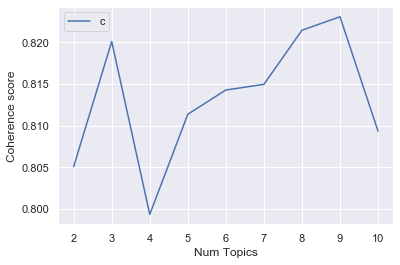

In [22]:
def compute_coherence_values(dictionary, corpus, texts, limit, start, step):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        print(num_topics)
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word,
                                                random_seed=1)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

start1 = 2 
limit1 = 11
step1 = 1

model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=start1, limit=limit1, step=step1)

x = range(start1, limit1, step1)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [23]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.8051
Num Topics = 3  has Coherence Value of 0.8201
Num Topics = 4  has Coherence Value of 0.7994
Num Topics = 5  has Coherence Value of 0.8114
Num Topics = 6  has Coherence Value of 0.8143
Num Topics = 7  has Coherence Value of 0.815
Num Topics = 8  has Coherence Value of 0.8214
Num Topics = 9  has Coherence Value of 0.8231
Num Topics = 10  has Coherence Value of 0.8093


In [24]:
optimal_model = model_list[7] # Number of Topics = 9

# optimal_model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=7, id2word=id2word)
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

[(0,
  '0.158*"small" + 0.132*"long" + 0.079*"trip" + 0.053*"past" + 0.053*"bore" + '
  '0.026*"wife" + 0.026*"coffee" + 0.026*"casual" + 0.026*"beach" + '
  '0.026*"local"'),
 (1,
  '0.129*"time" + 0.065*"lot" + 0.065*"food" + 0.032*"heavy" + '
  '0.032*"informative" + 0.032*"ahead" + 0.032*"poorly" + 0.032*"pink" + '
  '0.032*"lose" + 0.032*"pace"'),
 (2,
  '0.121*"hold" + 0.091*"street" + 0.061*"small" + 0.061*"green" + '
  '0.061*"nature" + 0.061*"memory" + 0.030*"suppose" + 0.030*"idyllic" + '
  '0.030*"forgettable" + 0.030*"pale"'),
 (3,
  '0.086*"tea" + 0.057*"grow" + 0.029*"cart" + 0.029*"live" + 0.029*"shoe" + '
  '0.029*"donkey" + 0.029*"pity" + 0.029*"receive" + 0.029*"hospitality" + '
  '0.029*"hide"'),
 (4,
  '0.097*"drive" + 0.065*"day" + 0.065*"secret" + 0.065*"expensive" + '
  '0.032*"target" + 0.032*"forever" + 0.032*"hour" + 0.032*"find" + '
  '0.032*"hearte" + 0.032*"building"'),
 (5,
  '0.154*"crocodile" + 0.103*"snake" + 0.077*"narrow" + 0.077*"oasis" + '
  '0.051*

In [25]:
optimal_model2 = gensim.models.wrappers.ldamallet.malletmodel2ldamodel(optimal_model)

# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(optimal_model2, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
5      0.041745  0.228782       1        1  11.199916
0     -0.300495 -0.074408       2        1  11.159557
7      0.180964 -0.177312       3        1  11.157577
3      0.106078 -0.235963       4        1  11.151026
2     -0.314738 -0.004721       5        1  11.145821
8     -0.100711  0.038065       6        1  11.128057
4      0.111091  0.281190       7        1  11.081754
1      0.123706 -0.167324       8        1  10.997680
6      0.152360  0.111690       9        1  10.978611, topic_info=    Category      Freq           Term     Total  loglift  logprob
0    Default  7.000000          worth  7.000000  30.0000  30.0000
40   Default  9.000000          small  9.000000  29.0000  29.0000
19   Default  6.000000      crocodile  6.000000  28.0000  28.0000
16   Default  5.000000         expect  5.000000  27.0000  27.0000
180  Default  5.000000     experience  5.000000  26.0000  26.0000
47   Default  5.000000           long  5.000000  25.0000  25.0000
23   Default  5.000000           time  5.000000  24.0000  24.0000
38   Default  5.000000           hold  5.000000  23.0000  23.0000
100  Default  4.000000          snake  4.000000  22.0000  22.0000
106  Default  4.000000           hard  4.000000  21.0000  21.0000
111  Default  4.000000          drive  4.000000  20.0000  20.0000
157  Default  3.000000           walk  3.000000  19.0000  19.0000
159  Default  3.000000         street  3.000000  18.0000  18.0000
62   Default  3.000000            tea  3.000000  17.0000  17.0000
124  Default  3.000000           trip  3.000000  16.0000  16.0000
168  Default  3.000000          oasis  3.000000  15.0000  15.0000
92   Default  3.000000         narrow  3.000000  14.0000  14.0000
17   Default  3.000000            gem  3.000000  13.0000  13.0000
28   Default  3.000000        tourist  3.000000  12.0000  12.0000
98   Default  3.000000          money  3.000000  11.0000  11.0000
126  Default  4.000000          green  4.000000  10.0000  10.0000
65   Default  4.000000           hide  4.000000   9.0000   9.0000
10   Default  2.000000           make  2.000000   8.0000   8.0000
95   Default  2.000000          guide  2.000000   7.0000   7.0000
137  Default  2.000000         animal  2.000000   6.0000   6.0000
140  Default  2.000000           tour  2.000000   5.0000   5.0000
45   Default  3.000000      expensive  3.000000   4.0000   4.0000
70   Default  2.000000         secret  2.000000   3.0000   3.0000
26   Default  2.000000            day  2.000000   2.0000   2.0000
230  Default  2.000000           food  2.000000   1.0000   1.0000
..       ...       ...            ...       ...      ...      ...
97    Topic9  1.419900         manage  1.419900   2.2092  -3.4012
101   Topic9  1.419900           blow  1.419900   2.2092  -3.4012
104   Topic9  1.419900        depress  1.419900   2.2092  -3.4012
110   Topic9  1.419900          write  1.419900   2.2092  -3.4012
121   Topic9  1.419900     sorounding  1.419900   2.2092  -3.4012
140   Topic9  2.839801           tour  2.839801   2.2092  -2.7081
180   Topic9  5.679602     experience  5.679602   2.2092  -2.0149
188   Topic9  1.419900       tortoise  1.419900   2.2092  -3.4012
195   Topic9  1.419900       evidence  1.419900   2.2092  -3.4012
203   Topic9  1.419900          check  1.419900   2.2092  -3.4012
209   Topic9  1.419900           fact  1.419900   2.2092  -3.4012
216   Topic9  1.419900           cold  1.419900   2.2092  -3.4012
217   Topic9  1.419900       elephant  1.419900   2.2092  -3.4012
12    Topic9  1.419900        careful  1.419900   2.2092  -3.4012
61    Topic9  1.419900          style  2.403796   1.6828  -3.4012
88    Topic9  1.419900       building  2.806907   1.5277  -3.4012
0     Topic9  0.000000          worth  7.871163     -inf     -inf
1     Topic9  0.000000           less  0.000000      NaN     -inf
2     Topic9  0.000000         travel  1.107099     -inf     -i

In [26]:
def format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=data)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,0.0,0.1111,"small, long, trip, past, bore, wife, coffee, c...",Disappointing
1,1,0.0,0.1111,"small, long, trip, past, bore, wife, coffee, c...",Terrible experience at Karen Blixen
2,2,0.0,0.1111,"small, long, trip, past, bore, wife, coffee, c...",Disappointed
3,3,7.0,0.1285,"worth, walk, guide, make, hide, animal, imagin...",Not worth the effort
4,4,0.0,0.1111,"small, long, trip, past, bore, wife, coffee, c...",Pathetic
5,5,8.0,0.1410,"hard, gem, money, tourist, service, city, gree...",Less travelled world
6,6,2.0,0.1285,"hold, street, small, green, nature, memory, su...","Dirty, crowded, unsafe"
7,7,0.0,0.1111,"small, long, trip, past, bore, wife, coffee, c...",A Peek into the Colonial past
8,8,3.0,0.1399,"tea, grow, cart, live, shoe, donkey, pity, rec...",Filthy bathroom and threadbare uniforms
9,9,0.0,0.1111,"small, long, trip, past, bore, wife, coffee, c...",Average


In [27]:
df_dominant_topic['Dominant_Topic'].value_counts()

0.0    84
1.0    20
5.0    20
6.0    19
7.0    19
8.0    17
2.0    15
4.0    13
3.0    13
Name: Dominant_Topic, dtype: int64

In [28]:
df_dominant_topic.to_csv('kenya_422.csv', index = False)

In [38]:
# import sys
# import numpy
# numpy.set_printoptions(threshold=sys.maxsize)

# Run 2

# df_dominant_topic[df_dominant_topic['Dominant_Topic'] == 0]['Text'].values # Topicless/Unidentifiable - 84
# df_dominant_topic[df_dominant_topic['Dominant_Topic'] == 1]['Text'].values # Food Criticism - 20
# df_dominant_topic[df_dominant_topic['Dominant_Topic'] == 2]['Text'].values # Topicless/Unidentifiable - 15
# df_dominant_topic[df_dominant_topic['Dominant_Topic'] == 3]['Text'].values # Bad Management - 13
# df_dominant_topic[df_dominant_topic['Dominant_Topic'] == 4]['Text'].values # Topicless/Unidentifiable - 13
# df_dominant_topic[df_dominant_topic['Dominant_Topic'] == 5]['Text'].values # Topicless/Unidentifiable - 20
# df_dominant_topic[df_dominant_topic['Dominant_Topic'] == 6]['Text'].values # Bad Management - 19
# df_dominant_topic[df_dominant_topic['Dominant_Topic'] == 7]['Text'].values # Bad Management - 19
# df_dominant_topic[df_dominant_topic['Dominant_Topic'] == 8]['Text'].values # Bad Management - 17

In [39]:
# import sys
# import numpy
# numpy.set_printoptions(threshold=sys.maxsize)

# Run 1

# df_dominant_topic[df_dominant_topic['Dominant_Topic'] == 0]['Text'].values # Expressing Disappointment - 91
# df_dominant_topic[df_dominant_topic['Dominant_Topic'] == 1]['Text'].values # Food Criticism - 31
# df_dominant_topic[df_dominant_topic['Dominant_Topic'] == 2]['Text'].values # Accessibility Criticism - 19
# df_dominant_topic[df_dominant_topic['Dominant_Topic'] == 3]['Text'].values # General Criticism - 18
# df_dominant_topic[df_dominant_topic['Dominant_Topic'] == 4]['Text'].values # Maintenance Criticism - 21
# df_dominant_topic[df_dominant_topic['Dominant_Topic'] == 5]['Text'].values # General Criticism - 24
# df_dominant_topic[df_dominant_topic['Dominant_Topic'] == 6]['Text'].values # General Criticism - 16

In [40]:
# Group top 5 sentences under each topic
sent_topics_sorteddf_mallet = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

# Show
sent_topics_sorteddf_mallet.head(10)

,Topic_Num,Topic_Perc_Contrib,Keywords,Text
0,0.0,0.1432,"small, long, trip, past, bore, wife, coffee, c...",a trip to the spicy past
1,1.0,0.1285,"time, lot, food, heavy, informative, ahead, po...",POOR DRAINAGE
2,2.0,0.1423,"hold, street, small, green, nature, memory, su...",Small nature park with small crocodile and tur...
3,3.0,0.1410,"tea, grow, cart, live, shoe, donkey, pity, rec...","Cool architecture, but dirty"
4,4.0,0.1285,"drive, day, secret, expensive, target, forever...",A well-kept secret!
5,5.0,0.1432,"crocodile, snake, narrow, oasis, history, bit,...",A little slice of History
6,6.0,0.1447,"experience, expect, tour, fact, building, depr...",Cold chicken with elephants
7,7.0,0.1453,"worth, walk, guide, make, hide, animal, imagin...","Dirty place, but worth walking through when in..."
8,8.0,0.1426,"hard, gem, money, tourist, service, city, gree...",Hard to believe the target was missed


In [41]:
sent_topics_sorteddf_mallet['Text'].values

array(['a trip to the spicy past', 'POOR DRAINAGE',
       'Small nature park with small crocodile and turtles to touch/hold',
       'Cool architecture, but dirty', 'A well-kept secret!',
       'A little slice of History', 'Cold chicken with elephants',
       'Dirty place, but worth walking through when in Nairobi',
       'Hard to believe the target was missed'], dtype=object)

In [42]:
# # Number of Documents for Each Topic
# topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()

# # Percentage of Documents for Each Topic
# topic_contribution = round(topic_counts/topic_counts.sum(), 4)

# # Topic Number and Keywords
# topic_num_keywords = df_topic_sents_keywords[['Dominant_Topic', 'Topic_Keywords']]

# # Concatenate Column wise
# df_dominant_topics = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)

# # Change Column names
# df_dominant_topics.columns = ['Dominant_Topic', 'Topic_Keywords', 'Num_Documents', 'Perc_Documents']

# # Show
# df_dominant_topics